<a href="https://colab.research.google.com/github/NarasimhanHari2004/Medical-Imaging-VAE-AI/blob/main/AI_DA2_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Medical Image Latent Space Visualization Using VQ-VAE**

## **Important Libraries**

This code snippet is using pip, a Python package manager, to install several packages: lightning, torchmetrics, and medmnist. The `-q` flag is for quiet mode, which suppresses output messages, and `--no-cache-dir` ensures that pip does not use any cache directory during the installation process.

In [ ]:
!pip install -q --no-cache-dir lightning torchmetrics medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 176.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 180.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 327.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 185.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 139.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 155.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 126.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 127.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.

This code snippet imports various libraries and modules necessary for building and training deep learning models for medical image analysis tasks. It imports libraries such as PyTorch, Lightning, TorchMetrics, and MedMNIST for handling medical image datasets. Additionally, it sets up the environment for visualizing images and configuring plotting settings. Finally, it suppresses warnings and sets up the plotting environment for visualizing medical images.

In [ ]:
try: import lightning as L
except:
    import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

from torchmetrics.image import (PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure)
from torchmetrics.regression import MeanAbsoluteError
from google.colab.patches import cv2_imshow

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torchvision.models import resnet18
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, Resize
from torchvision.datasets.utils import download_url

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from medmnist.dataset import MedMNIST
from medmnist.info import INFO, HOMEPAGE, DEFAULT_ROOT

from PIL import Image

from tqdm import tqdm_notebook

import os
import cv2
import random
import math
import warnings
import time

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

This code snippet defines several constants used throughout the code.

- `MAX_EPOCH`: Maximum number of epochs for training the model.
- `BATCH_SIZE`: Batch size used during training.
- `LR`: Learning rate for optimization algorithms.
- `INPUT_DIM`, `HIDDEN_DIM`, `N_EMBEDDING`, `OUTPUT_DIM`: Dimensions used for defining the neural network architecture.
- `IMAGE_SIZE`: Size of the input images (assuming square images).
- `DATASET`: List of medical image datasets to be used, including "dermamnist", "pneumoniamnist", "retinamnist", "breastmnist", and "bloodmnist". These are likely different types of medical image datasets available in the MedMNIST library.

In [ ]:
MAX_EPOCH = 32
BATCH_SIZE = 16
LR = 2e-2
INPUT_DIM = 3
HIDDEN_DIM = 2
N_EMBEDDING = 512
OUTPUT_DIM = 3
IMAGE_SIZE = 64

DATASET = ["dermamnist","pneumoniamnist","retinamnist","breastmnist","bloodmnist",]

## **Dataset**

### **Utils**

This code snippet defines an image transformation pipeline using the `Compose` class from the torchvision.transforms module. The pipeline consists of the following transformations applied sequentially to input images:

1. `Resize(IMAGE_SIZE)`: Resizes the input images to a square shape with dimensions specified by the `IMAGE_SIZE` constant.
2. `ToTensor()`: Converts the input images into PyTorch tensors.
3. `Lambda(lambda x: (x * 2) - 1)`: Applies a lambda function element-wise to each tensor, scaling the pixel values from the range [0, 1] to the range [-1, 1].

In [ ]:
image_transform = Compose([Resize(IMAGE_SIZE),ToTensor(),Lambda(lambda x: (x * 2) - 1),])

This code snippet defines a custom dataset class called `BiomedicalDataset`, inheriting from PyTorch's `data.Dataset` class. This dataset class is designed to handle biomedical image datasets, particularly from the MedMNIST library. Here's a breakdown of what it does:

- It initializes by loading data splits (train, validation, test) for each specified dataset from MedMNIST.
- It provides properties (`__train__`, `__val__`, `__test__`) to set the dataset split.
- The `__getitem__` method retrieves an image and applies the specified transformations.
- The `__len__` method returns the length of the dataset split.
- The `__repr__` method provides a string representation of the dataset.
- The `download` method downloads the dataset if it's not found locally.

This dataset class enables easy handling of various biomedical image datasets for training and evaluation.

In [ ]:
class BiomedicalDataset(data.Dataset):
    flags = DATASET

    def __init__(self,splits=["train", "val", "test"],transform=image_transform,download=True,root=DEFAULT_ROOT,):
        self.train_imgs = list()
        self.val_imgs = list()
        self.test_imgs = dict()

        for flag in self.flags:
            self.flag = flag
            for split in splits:
                self.info = INFO[self.flag]

                if root is not None and os.path.exists(root): self.root = root
                else: raise RuntimeError("Failed to setup the default `root` directory. Please specify and create the `root` directory manually.")

                if download:self.download()

                if not os.path.exists(os.path.join(self.root, "{}.npz".format(self.flag))):raise RuntimeError("Dataset not found. You can set `download=True` to download it")
                npz_file = np.load(os.path.join(self.root, "{}.npz".format(self.flag)))

                self.split = split
                self.transform = transform

                if self.split == "train": self.train_imgs += npz_file["train_images"].tolist()
                elif self.split == "val": self.val_imgs += npz_file["val_images"].tolist()
                elif self.split == "test":self.test_imgs[flag] = (npz_file["train_images"].tolist() + npz_file["test_images"].tolist() + npz_file["val_images"].tolist())
                else: raise ValueError

        del self.flag, self.root, self.info, self.split

    @property
    def __train__(self):
        self.split = "train"
        return self

    @property
    def __val__(self):
        self.split = "val"
        return self

    def __test__(self, flag):
        self.split = "test"
        self.flag = flag
        return self

    def __getitem__(self, index):
        try:
            if self.split == "train": img = np.array(self.train_imgs[index])
            elif self.split == "val": img = np.array(self.val_imgs[index])
            elif self.split == "test":img = np.array(self.test_imgs[self.flag][index])
        except: raise TypeError("Error while handling dataset's split type")

        img = Image.fromarray(img.astype(np.uint8))

        if len(img.getbands()) < 3: img = img.convert("RGB")
        if self.transform is not None: img = self.transform(img)

        return img

    def __len__(self):
        try:
            if self.split == "train": return len(self.train_imgs)
            elif self.split == "val": return len(self.val_imgs)
            elif self.split == "test":return len(self.test_imgs[self.flag])
        except: TypeError("Error while handling dataset's split type")


    def __repr__(self):
        _repr_indent = 4
        head = f"{self.__class__.__name__}"
        body = [f"Number of datapoints: {self.__len__()}"]
        body.append(f"Number of channels: 3")

        lines = [head] + [" " * _repr_indent + line for line in body]
        return "\n".join(lines)

    def download(self):
        try: download_url(url=self.info["url"], root=self.root, filename="{}.npz".format(self.flag), md5=self.info["MD5"],)
        except: raise RuntimeError("Something went wrong when downloading! Go to the homepage to download manually." + HOMEPAGE)

In [ ]:
biomedical_dataset = BiomedicalDataset()

100%|██████████| 19725078/19725078 [00:03<00:00, 6010287.19it/s]


Using downloaded and verified file: /root/.medmnist/dermamnist.npz
Using downloaded and verified file: /root/.medmnist/dermamnist.npz


100%|██████████| 4170669/4170669 [00:00<00:00, 7424113.96it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


100%|██████████| 3291041/3291041 [00:00<00:00, 5196913.71it/s]


Using downloaded and verified file: /root/.medmnist/retinamnist.npz
Using downloaded and verified file: /root/.medmnist/retinamnist.npz


100%|██████████| 559580/559580 [00:00<00:00, 6578161.72it/s]


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz


100%|██████████| 35461855/35461855 [00:00<00:00, 101449672.93it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


## **Model**

### **Utils**

This code snippet defines a utility class called `AvgMeter`. It is designed to calculate and keep track of average values during training or evaluation of a machine learning model. Here's what each part of the class does:

- `__init__`: Initializes the `AvgMeter` object. It takes an optional argument `complete` which defaults to `False`. If `complete` is set to `True`, the `show` method will return both the mean and standard deviation of the recorded scores.

- `reset`: Resets the internal state of the `AvgMeter` object. It clears the list of recorded scores.

- `update`: Appends a new value to the list of recorded scores.

- `score`: Returns the recorded scores as a numpy array.

- `show`: Calculates and returns either the mean value or both the mean and standard deviation of the recorded scores. If `complete` is set to `True`, it returns both the mean and standard deviation, otherwise, it returns only the mean.

In [ ]:
class AvgMeter(object):
    def __init__(self, complete=False):
        self.reset()
        self.complete = complete

    def reset(self): self.scores = []
    def update(self, val): self.scores.append(val)

    @property
    def score(self):
        score = [s.numpy() for s in self.scores]
        return score

    def show(self):
        scores = torch.stack(self.scores)

        if self.complete:
            mean = torch.mean(scores)
            std = torch.std(scores)
            return mean, std
        else: return torch.mean(scores)

In [ ]:
class DataPoint:
    x = 0.
    y = 0.
    color = 'red'
    marker = 'o'
    label = None

### **Encoder**

This code snippet defines a PyTorch module called `Encoder`, which is a neural network encoder based on the ResNet18 architecture. Here's what it does:

- In the `__init__` method:
  - It initializes the `Encoder` module by inheriting from `nn.Module`.
  - It loads the ResNet18 backbone using `torch.hub.load` from the torchvision models repository, with pretrained weights.
  - It removes the last two layers (`layer3`, `layer4`) from the ResNet18 backbone, as well as the average pooling layer (`avgpool`) and the fully connected layer (`fc`).
  - It defines a custom layer (`layer3`) consisting of convolutional and batch normalization layers.

- In the `forward` method:
  - It applies the initial convolutional, batch normalization, and activation layers (`conv1`, `bn1`, `relu`, `maxpool`) from the ResNet18 backbone to the input data (`x`).
  - It passes the data through the first two layers of the ResNet18 backbone (`layer1`, `layer2`).
  - It passes the output through the custom `layer3` defined earlier.

The `Encoder` module is intended to encode input images into a lower-dimensional feature representation using the ResNet18 architecture with modifications.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()

        self.backbone = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        del self.backbone.layer3, self.backbone.layer4
        del self.backbone.avgpool, self.backbone.fc

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, hidden_dim, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_dim),
        )

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)

        x = self.layer3(x)

        return x

### **Vector Quantizer Embedding Exponential Moving Average**

This code snippet defines a PyTorch module called `VQEmbeddingEMA`, which implements Vector Quantization (VQ) with an Exponential Moving Average (EMA) update mechanism for the embedding vectors. Here's a breakdown of the class functionality:

- **Initialization**:
  - The constructor initializes the parameters including `n_embeddings` (number of embeddings), `embedding_dim` (dimensionality of embeddings), `commitment_cost` (a hyperparameter for controlling the impact of the commitment loss), `decay` (exponential moving average decay rate), and `epsilon` (a small constant to avoid division by zero).
  - It initializes the embedding vectors randomly with values uniformly sampled from a range determined by `init_bound`.

- **Encode method**:
  - Computes the distances between input vectors and embedding vectors and quantizes input vectors to the nearest embedding vector.
  - Returns the quantized vectors.

- **Retrieve_random_codebook method**:
  - Retrieves random embedding vectors based on given indices.

- **Forward method**:
  - Computes distances between input vectors and embedding vectors, quantizes input vectors, and computes losses including commitment loss and codebook loss.
  - If in training mode, updates the EMA statistics for the embedding vectors.
  - Computes and returns the quantized vectors, commitment loss, codebook loss, and perplexity.

This module is used for vector quantization-based compression and feature learning, commonly used in autoencoder-based architectures.

In [ ]:
class VQEmbeddingEMA(nn.Module):
    def __init__(
        self,
        n_embeddings,
        embedding_dim,
        commitment_cost=0.25,
        decay=0.999,
        epsilon=1e-5,
    ):
        super(VQEmbeddingEMA, self).__init__()
        self.commitment_cost = commitment_cost
        self.decay = decay
        self.epsilon = epsilon

        init_bound = 1 / n_embeddings
        embedding = torch.Tensor(n_embeddings, embedding_dim)
        embedding.uniform_(-init_bound, init_bound)
        self.register_buffer("embedding", embedding)
        self.register_buffer("ema_count", torch.zeros(n_embeddings))
        self.register_buffer("ema_weight", self.embedding.clone())

    def encode(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(
            torch.sum(self.embedding**2, dim=1)
            + torch.sum(x_flat**2, dim=1, keepdim=True),
            x_flat,
            self.embedding.t(),
            alpha=-2.0,
            beta=1.0,
        )

        indices = torch.argmin(distances.float(), dim=-1)
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)

        return quantized

    def retrieve_random_codebook(self, random_indices):
        quantized = F.embedding(random_indices, self.embedding)
        quantized = quantized.transpose(1, 3)

        return quantized

    def forward(self, x):
        M, D = self.embedding.size()
        x_flat = x.detach().reshape(-1, D)

        distances = torch.addmm(
            torch.sum(self.embedding**2, dim=1)
            + torch.sum(x_flat**2, dim=1, keepdim=True),
            x_flat,
            self.embedding.t(),
            alpha=-2.0,
            beta=1.0,
        )

        indices = torch.argmin(distances.float(), dim=-1)
        encodings = F.one_hot(indices, M).float()
        quantized = F.embedding(indices, self.embedding)
        quantized = quantized.view_as(x)

        if self.training:
            self.ema_count = self.decay * self.ema_count + (1 - self.decay) * torch.sum(encodings, dim=0)
            n = torch.sum(self.ema_count)
            self.ema_count = ((self.ema_count + self.epsilon) / (n + M * self.epsilon) * n)

            dw = torch.matmul(encodings.t(), x_flat)
            self.ema_weight = self.decay * self.ema_weight + (1 - self.decay) * dw
            self.embedding = self.ema_weight / self.ema_count.unsqueeze(-1)

        codebook_loss = F.mse_loss(x.detach(), quantized)
        e_latent_loss = F.mse_loss(x, quantized.detach())
        commitment_loss = self.commitment_cost * e_latent_loss

        quantized = x + (quantized - x).detach()

        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return quantized, commitment_loss, codebook_loss, perplexity

### **Decoder**

This code snippet defines a PyTorch module called `Decoder`. This module is responsible for decoding the quantized vectors back into the original input space. Here's a summary of what the class does:

- **Initialization**:
  - The constructor initializes the decoder module by inheriting from `nn.Module`.
  - It defines several convolutional layers (`conv1`, `conv2`, `conv3`, `conv4`) interleaved with batch normalization and ReLU activation.
  - Each convolutional layer is followed by a skip connection, where the input is added to the output of the convolutional layer before the activation function.
  - Transposed convolutional layers (`convtranspose1`, `convtranspose2`, `convtranspose3`, `convtranspose4`) are used for upsampling the feature maps.
  - The final convolutional layer (`final_conv`) produces the output image with three channels (assuming RGB images).

- **Forward Method**:
  - The forward method defines the forward pass of the decoder.
  - It passes the input through the convolutional layers with skip connections and upsampling layers.
  - Finally, it applies the final convolutional layer to produce the reconstructed image.

This decoder module complements the encoder module in an autoencoder architecture, reconstructing the input images from the learned latent space representations.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim,):
        super(Decoder, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(input_dim, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convskip1 = nn.Sequential(
            nn.Conv2d(input_dim, 64, 1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convtranspose1 = nn.ConvTranspose2d(64, 64, 2, 2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convskip2 = nn.Sequential(
            nn.Conv2d(64, 64, 1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convtranspose2 = nn.ConvTranspose2d(64, 64, 2, 2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convskip3 = nn.Sequential(
            nn.Conv2d(64, 64, 1, bias=False),
            nn.BatchNorm2d(64),
        )
        self.convtranspose3 = nn.ConvTranspose2d(64, 64, 2, 2)

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
        )
        self.convskip4 = nn.Sequential(
            nn.Conv2d(64, 32, 1, bias=False),
            nn.BatchNorm2d(32),
        )
        self.convtranspose4 = nn.ConvTranspose2d(32, 32, 2, 2)
        self.final_conv = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x) + self.convskip1(x)
        x = self.convtranspose1(x)

        x = self.conv2(x) + self.convskip2(x)
        x = self.convtranspose2(x)

        x = self.conv3(x) + self.convskip3(x)
        x = self.convtranspose3(x)

        x = self.conv4(x) + self.convskip4(x)
        x = self.convtranspose4(x)

        return self.final_conv(x)

### **VQ-VAE (Vector-Quantized Variational AutoEncoder)**

This code snippet defines a PyTorch Lightning module called `VQVAE`, which implements a Variational Autoencoder with Vector Quantization (VQ-VAE) architecture. Here's a summary of what the class does:

- **Initialization**:
  - It initializes the VQ-VAE module by inheriting from `LightningModule`.
  - It takes the encoder, codebook, and decoder modules as arguments along with batch size, learning rate, and maximum number of epochs.
  - It initializes various attributes to track training and validation metrics.

- **Forward Method**:
  - The `forward` method defines the forward pass of the VQ-VAE.
  - It passes the input through the encoder, codebook, and decoder modules.
  - It returns the reconstructed image along with commitment loss, codebook loss, and perplexity.

- **Training and Validation Steps**:
  - The `training_step` and `validation_step` methods define the operations performed during each training and validation step, respectively.
  - They compute the reconstruction loss along with other losses and metrics.
  - They update the metrics and record them for visualization.

- **Epoch End Methods**:
  - The `on_train_epoch_end` and `on_validation_epoch_end` methods are called at the end of each training and validation epoch, respectively.
  - They aggregate and record the metrics for visualization.

- **Test Step**:
  - The `test_step` method defines the operations performed during the testing phase.
  - It computes the latent embedding of input data and stores metadata for visualization.

- **Optimizers and Learning Rate Scheduler**:
  - The `configure_optimizers` method configures the optimizer and learning rate scheduler for training.

- **Data Loaders**:
  - The `train_dataloader` and `val_dataloader` methods define the training and validation data loaders, respectively.

- **Plotting Evaluation Metrics**:
  - The `_plot_evaluation_metrics` method plots and saves evaluation metrics such as total loss, PSNR, SSIM, and MAE.

This module facilitates training, validation, and testing of the VQ-VAE architecture while providing visualization of training progress and evaluation metrics.

In [ ]:
class VQVAE(L.LightningModule):
    def __init__(self, encoder, codebook, decoder, batch_size, lr, max_epoch):
        super().__init__()

        self.encoder = encoder
        self.codebook = codebook
        self.decoder = decoder

        self.batch_size = batch_size
        self.lr = lr
        self.max_epoch = max_epoch

        self.datapoints = list()

        self.train_psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.train_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.train_mae = MeanAbsoluteError()

        self.val_psnr = PeakSignalNoiseRatio(data_range=1.0)
        self.val_ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        self.val_mae = MeanAbsoluteError()

        self.train_psnr_recorder = AvgMeter()
        self.train_ssim_recorder = AvgMeter()
        self.train_mae_recorder = AvgMeter()

        self.val_psnr_recorder = AvgMeter()
        self.val_ssim_recorder = AvgMeter()
        self.val_mae_recorder = AvgMeter()

        self.train_psnr_list = list()
        self.train_ssim_list = list()
        self.train_mae_list = list()

        self.val_psnr_list = list()
        self.val_ssim_list = list()
        self.val_mae_list = list()

        self.train_total_loss_recorder = AvgMeter()
        self.val_total_loss_recorder = AvgMeter()

        self.train_total_loss = list()
        self.val_total_loss = list()

        self.sanity_check_counter = 1

        self.automatic_optimization = False

    def forward(self, x):
        z = self.encoder(x)
        z_quantized, commitment_loss, codebook_loss, perplexity = self.codebook(z)
        x_hat = self.decoder(z_quantized)
        return x_hat, commitment_loss, codebook_loss, perplexity

    def latent_embedding(self, x):
        z = self.encoder(x)
        result = self.codebook.encode(z)
        return result.mean(dim=[2,3])

    def test_step(self, batch, batch_nb):
        x = batch
        latent = self.latent_embedding(x).squeeze(0).data.cpu().numpy()
        datapoint = DataPoint()
        datapoint.x = latent[0]
        datapoint.y = latent[1]
        datapoint.label = self.dataset_name


        if self.dataset_name == "dermamnist":
            datapoint.color = "blue"
            datapoint.marker = "o"
        elif self.dataset_name == "pneumoniamnist":
            datapoint.color = "purple"
            datapoint.marker = "s"
        elif self.dataset_name == "retinamnist":
            datapoint.color = "green"
            datapoint.marker = "s"
        elif self.dataset_name == "breastmnist":
            datapoint.color = "black"
            datapoint.marker = "P"
        elif self.dataset_name == "bloodmnist":
            datapoint.color = "gold"
            datapoint.marker = "P"
        else: raise TypeError(f"Unidentified dataset_name: {self.dataset_name}")

        self.datapoints.append(datapoint)

    def training_step(self, batch, batch_nb):

        x = batch
        x_hat, commitment_loss, codebook_loss, perplexity = self(x)
        recon_loss = F.mse_loss(x_hat, x)
        total_loss = recon_loss + commitment_loss + codebook_loss

        opt = self.optimizers()
        opt.zero_grad()
        self.manual_backward(total_loss)
        opt.step()

        self.log("train_total_loss",total_loss,prog_bar=True,)
        self.train_total_loss_recorder.update(total_loss.data)

        self.train_psnr.update(x_hat, x)
        psnr = self.train_psnr.compute().data.cpu()

        self.train_ssim.update(x_hat, x)
        ssim = self.train_ssim.compute().data.cpu()

        self.train_mae.update(x_hat, x)
        mae = self.train_mae.compute().data.cpu()

        self.log("train_psnr", psnr, prog_bar=True)
        self.log("train_ssim", ssim, prog_bar=True)
        self.log("train_mae", mae, prog_bar=True)

        self.train_psnr_recorder.update(psnr)
        self.train_ssim_recorder.update(ssim)
        self.train_mae_recorder.update(mae)

    def on_train_epoch_end(self):
        mean = self.train_total_loss_recorder.show()
        self.train_total_loss.append(mean.data.cpu().numpy())
        self.train_total_loss_recorder = AvgMeter()

        mean = self.train_mae_recorder.show()
        self.train_mae_list.append(mean.data.cpu().numpy())
        self.train_mae_recorder = AvgMeter()

        mean = self.train_psnr_recorder.show()
        self.train_psnr_list.append(mean.data.cpu().numpy())
        self.train_psnr_recorder = AvgMeter()

        mean = self.train_ssim_recorder.show()
        self.train_ssim_list.append(mean.data.cpu().numpy())
        self.train_ssim_recorder = AvgMeter()

        self._plot_evaluation_metrics()

    def validation_step(self, batch, batch_nb):
        x = batch
        x_hat, commitment_loss, codebook_loss, perplexity = self(x)
        recon_loss = F.mse_loss(x_hat, x)
        total_loss = recon_loss + commitment_loss + codebook_loss

        self.log("val_total_loss",total_loss,prog_bar=True,)
        self.val_total_loss_recorder.update(total_loss.data)

        self.val_psnr.update(x_hat, x)
        psnr = self.val_psnr.compute().data.cpu()

        self.val_ssim.update(x_hat, x)
        ssim = self.val_ssim.compute().data.cpu()

        self.val_mae.update(x_hat, x)
        mae = self.val_mae.compute().data.cpu()

        self.log("val_psnr", psnr, prog_bar=True)
        self.log("val_ssim", ssim, prog_bar=True)
        self.log("val_mae", mae, prog_bar=True)

        self.val_psnr_recorder.update(psnr)
        self.val_ssim_recorder.update(ssim)
        self.val_mae_recorder.update(mae)

    def on_validation_epoch_end(self):
        mean = self.val_total_loss_recorder.show()
        self.val_total_loss.append(mean.data.cpu().numpy())
        self.val_total_loss_recorder = AvgMeter()

        mean = self.val_mae_recorder.show()
        self.val_mae_list.append(mean.data.cpu().numpy())
        self.val_mae_recorder = AvgMeter()

        mean = self.val_psnr_recorder.show()
        self.val_psnr_list.append(mean.data.cpu().numpy())
        self.val_psnr_recorder = AvgMeter()

        mean = self.val_ssim_recorder.show()
        if self.sanity_check_counter == 0:
            sch = self.lr_schedulers()
            sch.step(mean)
            print(f"[{MODEL_NAME}] Learning Rate: {self.optimizers().param_groups[0]['lr']}")
        else: self.sanity_check_counter -= 1
        self.val_ssim_list.append(mean.data.cpu().numpy())
        self.val_ssim_recorder = AvgMeter()

    def set_test_metadata(self, dataset_name): self.dataset_name = dataset_name
    def _plot_evaluation_metrics(self):
        # Total Loss
        loss_img_file = (
            f"{EXPERIMENT_DIR}/{MODEL_NAME}_total_loss_plot.png"
        )
        plt.plot(self.train_total_loss, color="r", label="train")
        plt.plot(self.val_total_loss[1:], color="b", label="validation")
        plt.title("Total Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.clf()

        # PSNR
        psnr_img_file = f"{EXPERIMENT_DIR}/{MODEL_NAME}_psnr_plot.png"
        plt.plot(self.train_psnr_list, color="r", label="train")
        plt.plot(self.val_psnr_list[1:], color="b", label="validation")
        plt.title("PSNR Curves")
        plt.xlabel("Epoch")
        plt.ylabel("PSNR")
        plt.legend()
        plt.grid()
        plt.savefig(psnr_img_file)
        plt.clf()

        # SSIM
        ssim_img_file = f"{EXPERIMENT_DIR}/{MODEL_NAME}_ssim_plot.png"
        plt.plot(self.train_ssim_list, color="r", label="train")
        plt.plot(self.val_ssim_list[1:], color="b", label="validation")
        plt.title("SSIM Curves")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM")
        plt.legend()
        plt.grid()
        plt.savefig(ssim_img_file)
        plt.clf()

        # MAE
        mae_img_file = f"{EXPERIMENT_DIR}/{MODEL_NAME}_mae_plot.png"
        plt.plot(self.train_mae_list, color="r", label="train")
        plt.plot(self.val_mae_list[1:], color="b", label="validation")
        plt.title("MAE Curves")
        plt.xlabel("Epoch")
        plt.ylabel("MAE")
        plt.legend()
        plt.grid()
        plt.savefig(mae_img_file)
        plt.clf()

    def train_dataloader(self):
        return data.DataLoader(
            dataset=biomedical_dataset.__train__,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=biomedical_dataset.__val__,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.SGD(
            self.parameters(),
            lr=self.lr,
            weight_decay=1e-3,
            momentum=0.9,
            nesterov=True,
        )
        lr_scheduler = {
            "scheduler": optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                mode="max",
                factor=0.1,
                patience=2,
            ),
            "name": "lr_scheduler",
        }
        return [optimizer], [lr_scheduler]

In [ ]:
MODEL = VQVAE
MODEL_NAME = MODEL.__name__

In [ ]:
EXPERIMENT_DIR = "/content/"
BEST_MODEL_PATH = os.path.join(EXPERIMENT_DIR, f"{MODEL_NAME}_best.ckpt")

## **Training**

In [ ]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1418961754


This code defines a training loop `_train_loop` that trains a VQ-VAE model. Here's a breakdown of the code:

- It first sets the random seed using `seed_everything` to ensure reproducibility.

- It initializes the encoder, codebook, and decoder components of the VQ-VAE architecture.

- It creates the VQVAE model using the specified components (encoder, codebook, decoder) along with other hyperparameters such as batch size, learning rate, and maximum number of epochs.

- It sets up a model checkpoint to save the best model based on validation SSIM score.

- It sets up early stopping to prevent overfitting and terminate training if the validation SSIM score doesn't improve for a certain number of epochs.

- It checks if a pre-trained model checkpoint exists, and if so, it loads it.

- It initializes the PyTorch Lightning Trainer with appropriate settings such as accelerator, number of devices, maximum epochs, logging, and callbacks (model checkpoint and early stopping).

- Finally, it starts the training process using `trainer.fit(model, ckpt_path=ckpt_path)`.

This loop trains the VQ-VAE model and saves the best model based on validation SSIM score while applying early stopping to prevent overfitting.

In [ ]:
model, trainer, checkpoint, early_stopping = None, None, None, None


def _train_loop():
    seed_everything(SEED, workers=True)

    ENCODER = Encoder(hidden_dim=HIDDEN_DIM)
    CODEBOOK = VQEmbeddingEMA(n_embeddings=N_EMBEDDING, embedding_dim=HIDDEN_DIM)
    DECODER = Decoder(input_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

    model = MODEL(ENCODER, CODEBOOK, DECODER, BATCH_SIZE, LR, MAX_EPOCH)

    checkpoint = ModelCheckpoint(
        monitor='val_ssim',
        dirpath=EXPERIMENT_DIR,
        mode='max',
        filename=f"{MODEL_NAME}_best",
    )
    print(MODEL_NAME)
    early_stopping = EarlyStopping(
        monitor="val_ssim", min_delta=0.00, patience=8, verbose=False, mode="max"
    )

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=MAX_EPOCH,
        logger=False,
        callbacks=[checkpoint, early_stopping],
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)

_train_loop()

INFO: Seed set to 1418961754
INFO:lightning.fabric.utilities.seed:Seed set to 1418961754
Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s]


VQVAE


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type                             | Params
----------------------------------------------------------------
0 | encoder    | Encoder                          | 831 K 
1 | codebook   | VQEmbeddingEMA                   | 0     
2 | decoder    | Decoder                          | 317 K 
3 | train_psnr | PeakSignalNoiseRatio             | 0     
4 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.02


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


Validation: |          | 0/? [00:00<?, ?it/s]

[VQVAE] Learning Rate: 0.002


INFO: `Trainer.fit` stopped: `max_epochs=32` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=32` reached.


<Figure size 640x480 with 0 Axes>

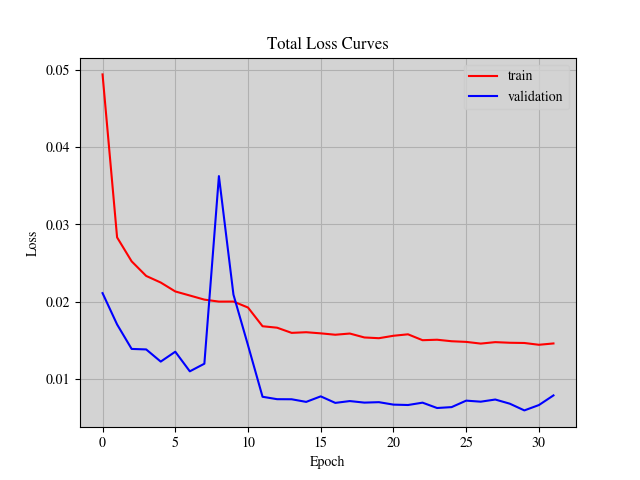

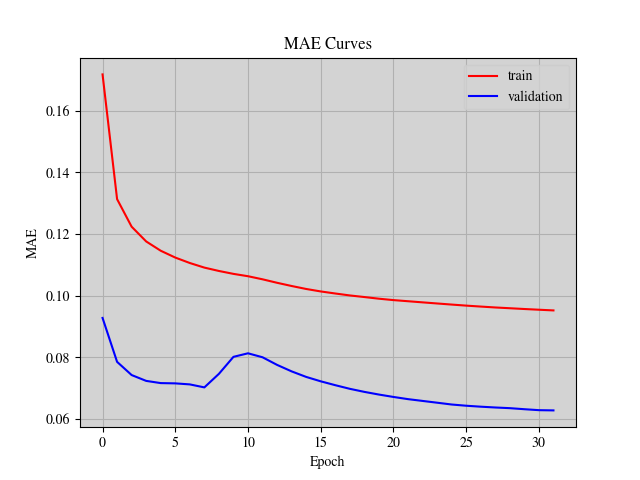

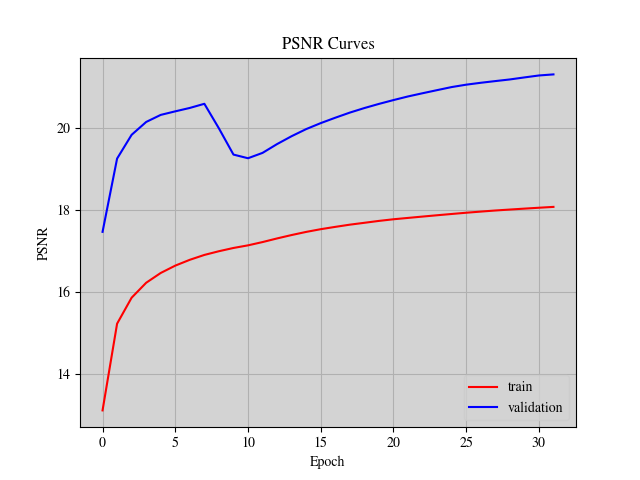

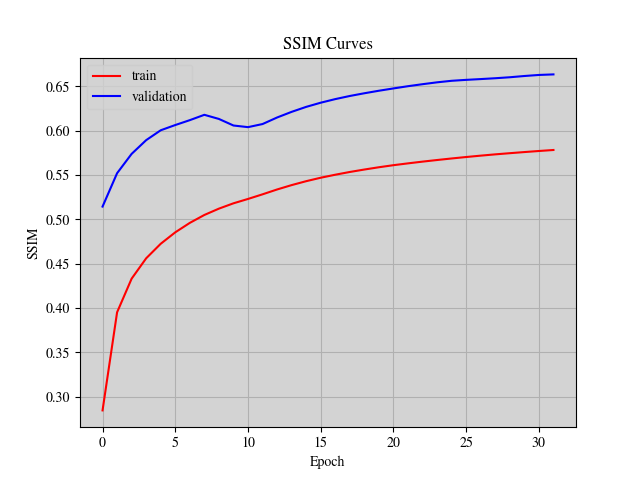

In [ ]:
img = cv2.imread(f"{EXPERIMENT_DIR}/{MODEL_NAME}_total_loss_plot.png")
cv2_imshow(img)
img = cv2.imread(f"{EXPERIMENT_DIR}/{MODEL_NAME}_mae_plot.png")
cv2_imshow(img)
img = cv2.imread(f"{EXPERIMENT_DIR}/{MODEL_NAME}_psnr_plot.png")
cv2_imshow(img)
img = cv2.imread(f"{EXPERIMENT_DIR}/{MODEL_NAME}_ssim_plot.png")
cv2_imshow(img)
del img

## **Inference**

### **Utils**

This function `confidence_ellipse` plots a confidence ellipse for bivariate data on a given matplotlib axes object. Here's a breakdown of its functionality:

- **Parameters**:
  - `x`, `y`: Arrays containing the bivariate data points.
  - `ax`: Matplotlib axes object where the ellipse will be plotted.
  - `n_std`: Number of standard deviations defining the size of the ellipse. By default, it's set to 3.0.
  - `facecolor`: Face color of the ellipse. By default, it's set to 'none', meaning no face color.

- **Functionality**:
  - It computes the covariance matrix between `x` and `y` using `np.cov(x, y)`.
  - It calculates the Pearson correlation coefficient between `x` and `y`.
  - It computes the radii of the ellipse along the x and y axes using the eigenvalues of the covariance matrix.
  - It creates an `Ellipse` object with appropriate parameters (center, width, height, facecolor) representing the confidence ellipse.
  - It computes the scale and mean values for both x and y.
  - It applies an affine transformation to the ellipse, including rotation, scaling, and translation, based on the standard deviations and means calculated earlier.
  - It adds the transformed ellipse patch to the specified axes object (`ax`).

This function is useful for visually representing the distribution and correlation of bivariate data points by plotting a confidence ellipse around them. The size and orientation of the ellipse are determined by the covariance between the variables.

In [ ]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size: raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,facecolor=facecolor, linewidth=3, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### **Gather the Vector Quantized Latent Representation**

This code snippet appears to be for evaluating the trained VQ-VAE model on multiple datasets using PyTorch Lightning Trainer's `test` method. Here's what it does:

- It initializes a PyTorch Lightning Trainer object with auto-accelerator and logging disabled.

- It initializes the components of the VQ-VAE model: encoder, codebook, and decoder.

- It loops over each dataset name in the `DATASET` list.

- For each dataset:
  - It sets the metadata for testing by calling `model.set_test_metadata(dataset_name=dataset_name)`.
  - It calls the `trainer.test()` method to evaluate the model on the test dataset.
  - Within `trainer.test()`:
    - It passes the model and the best model checkpoint path (`BEST_MODEL_PATH`).
    - It defines a `DataLoader` for the test dataset of the current dataset using `biomedical_dataset.__test__(dataset_name)`.
    - It sets the batch size to 1 and shuffle to False for the test `DataLoader`.
    
- During testing, the model's `test_step` method is invoked for each batch in the test dataset, where relevant metrics are computed and logged.

- The evaluation results are printed for each dataset.

This snippet allows for convenient testing of the VQ-VAE model on multiple datasets and provides insights into its performance across different domains.

In [ ]:
trainer = Trainer(accelerator='auto', logger=False)

ENCODER = Encoder(hidden_dim=HIDDEN_DIM)
CODEBOOK = VQEmbeddingEMA(n_embeddings=N_EMBEDDING, embedding_dim=HIDDEN_DIM)
DECODER = Decoder(input_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

model = MODEL(ENCODER, CODEBOOK, DECODER, BATCH_SIZE, LR, MAX_EPOCH)

for dataset_name in DATASET:
    print(f"======================{dataset_name}==============================")
    model.set_test_metadata(dataset_name=dataset_name)
    trainer.test(
        model=model,
        ckpt_path=BEST_MODEL_PATH,
        dataloaders=data.DataLoader(
                dataset=biomedical_dataset.__test__(dataset_name),
                batch_size=1,
                shuffle=False,
        ),
    )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
INFO: Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_

======================dermamnist==============================


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/VQVAE_best.ckpt


======================pneumoniamnist==============================


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/VQVAE_best.ckpt


======================retinamnist==============================


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/VQVAE_best.ckpt


======================breastmnist==============================


Testing: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/VQVAE_best.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/VQVAE_best.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/VQVAE_best.ckpt


======================bloodmnist==============================


Testing: |          | 0/? [00:00<?, ?it/s]

### **Visualize the Latent Space**

This code snippet generates a scatter plot of the latent space representations of data points produced by the VQ-VAE model, with confidence ellipses around the clusters. Here's a breakdown of its functionality:

- It initializes a new figure and axes for plotting.
- It iterates over each datapoint stored in `model.datapoints`.
- For each datapoint:
  - It extracts the coordinates (`x` and `y`) and label (`label`).
  - It adds the datapoint to the scatter plot using `ax.scatter()`, with color and marker specified based on the dataset label. It also manages the legend labels to avoid duplication.
- It computes and plots confidence ellipses for each dataset using the `confidence_ellipse` function.
- It adjusts the limits of the plot to provide some margin around the data points.
- It turns off the axis lines.
- It adds a legend to the plot indicating the dataset labels.
- It saves the plot as a PDF file in the specified experiment directory (`EXPERIMENT_DIR`).

This code snippet aims to visualize the distribution of latent space representations learned by the VQ-VAE model across different datasets, helping to understand the clustering and separation of data points in the latent space.

  0%|          | 0/35343 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

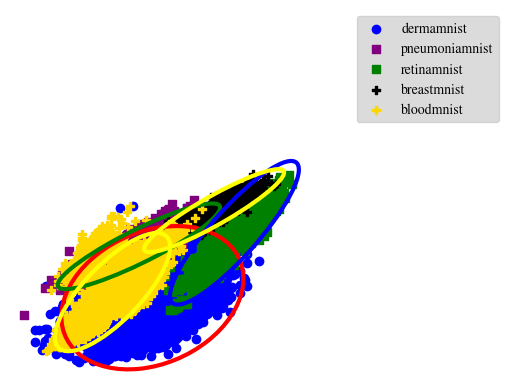

In [ ]:
plt.clf()
fig, ax = plt.subplots()
has_been_called = set()
points = {dataset: list() for dataset in DATASET}

for datapoint in tqdm_notebook(model.datapoints):
    x = datapoint.x
    y = datapoint.y
    label = datapoint.label
    points[label].append([x, y])
    ax.scatter(
        x,
        y,
        c=datapoint.color,
        marker=datapoint.marker,
        label=label if label not in has_been_called else "",
    )
    has_been_called.add(label)

for dataset_name, dataset in points.items():
    if dataset_name == "dermamnist":
        color = "red"
    elif dataset_name == "pneumoniamnist":
        color = "green"
    elif dataset_name == "retinamnist":
        color = "blue"
    elif dataset_name == "breastmnist":
        color = "yellow"
    elif dataset_name == "bloodmnist":
        color = "black"
    dataset = np.array(dataset)
    confidence_ellipse(dataset[:, 0], dataset[:, 1], ax, edgecolor=color)

min_, max_ = plt.xlim()
ax.set_xlim([min_, 2.25 * max_])
min_, max_ = plt.ylim()
ax.set_ylim([min_, 2.25 * max_])
plt.axis('off')
plt.legend(loc="upper right")
plt.savefig(f"{EXPERIMENT_DIR}/latent_space.pdf")